# Статистические методы

## Хи-квадрат
Для каждого слова по двум корпусам можно построить таблицу сопряженности:

<table align="center">
    <tr>
        <td></td>
        <td>Target</td>
        <td>Reference</td>
        <td>Total (row sum)</td>
    </tr>
    <tr>
        <td>Word</td>
        <td>$O_{11}$=a</td>
        <td>$O_{12}$=b</td>
        <td>${T'}_1$=a+b</td>
    </tr>
    <tr>
        <td>Not word</td>
        <td>$O_{21}$=c-a</td>
        <td>$O_{22}$=d-b</td>
        <td>${T'}_2$=c+d-a-b</td>
    </tr>
    <tr>
        <td>Total (column sum)</td>
        <td>$T_1$=c</td>
        <td>$T_2$=d</td>
        <td>$N$=c+d</td>
    </tr>
</table>

Ожидаемую частоту оценим так:
$E_{ij}=\frac{T_i*{T'}_j}{N}$

Тогда для $\chi^2$ справедливо следующее:

$$\chi^2 = \sum{\frac{(O_{ij}-E_{ij})^2}{E_{ij}}} = \frac{N(O_{11}O_{22}-O_{12}O_{21})}{(O_{11}+O_{12})(O_{11}+O_{21})(O_{12}+O_{22})(O_{21}+O_{22})}$$


In [22]:
#!pip install scipy
#!pip install wikipedia

In [23]:
from scipy.stats import chi2_contingency
import wikipedia

In [24]:
# Скачивалка статей Википедии
def download_wiki_texts(n, lang='ru'):
    wikipedia.set_lang(lang)
    pages = wikipedia.random(n)
    wiki_content_list = []
    for page_name in pages:
        try:
            page = wikipedia.page(page_name)
            wiki_content_list.append(page.content.replace('=', ''))
        except wikipedia.exceptions.WikipediaException:
            print("Skip %s" % page_name)
    return '\n'.join(wiki_content_list)

In [25]:
wiki_content = download_wiki_texts(20)

c:\program files\python37\lib\site-packages\wikipedia\wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\program files\python37\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Skip Холчевка


In [26]:
from pymorphy2 import MorphAnalyzer
from pymorphy2.tokenizers import simple_word_tokenize

In [27]:
# Лемматизация текстов
m = MorphAnalyzer()
def normalize_text(text):
    lemmas = []
    for t in simple_word_tokenize(text):
        lemmas.append(
            m.parse(t)[0].normal_form
        )
    return ' '.join(lemmas)

In [28]:
bbc_text = """
Королева Британии Елизавета II приняла решение отказаться от одежды и аксессуаров из натурального меха, сообщил Букингемский дворец. Некоторые королевские наряды уже перешиты.
О том, что королева отказывается от натурального меха, написала в своей книге "Другая сторона монеты: королева, модельер и платяной шкаф" личный костюмер королевы Анджела Келли.
"Если Ее Величеству придется посещать какое-либо мероприятие в очень холодную погоду, с 2019 года, чтобы не замерзнуть, она будет надевать одежду из искусственного меха", - рассказала личный костюмер королевы Анджела Келли.
Пресс-секретарь Букингемского дворца подтвердил, что для пошива новой одежды для королевы при необходимости будет использоваться только искусственный мех.
При этом, как уточнили в Букингемском дворце, королева продолжит носить те меховые изделия, которые были приобретены или созданы для нее ранее - от шляп до церемониальных мантий.
В своей книге Анджела Келли рассказывает, что мех норки на пальто, которое было на королеве во время ее визита в Словакию в 2008 году, сейчас заменен на искусственный.
Королеву неоднократно критиковали за то, что она продолжала носить меховые изделия, когда от использования меха отказались почти все модные дома, признав использование меха для изготовления одежды и аксессуаров жестоким решением.
"""

In [29]:
test_words = normalize_text(bbc_text).split()
ref_words = normalize_text(wiki_content).split()

Напишем функцию, которая будет принимать на вход 
- лемму
- целевой текст в виде списка лемм
- контрастный текст в виде списка лемм

И возвращать таблицу сопряженности (contingency table):
<table align="center">
    <tr>
        <td></td>
        <td>Target</td>
        <td>Reference</td>
        <td>Total (row sum)</td>
    </tr>
    <tr>
        <td>Word</td>
        <td>$O_{11}$=a</td>
        <td>$O_{12}$=b</td>
        <td>${T'}_1$=a+b</td>
    </tr>
    <tr>
        <td>Not word</td>
        <td>$O_{21}$=c-a</td>
        <td>$O_{22}$=d-b</td>
        <td>${T'}_2$=c+d-a-b</td>
    </tr>
    <tr>
        <td>Total (column sum)</td>
        <td>$T_1$=c</td>
        <td>$T_2$=d</td>
        <td>$N$=c+d</td>
    </tr>
</table>
В виде списка $[ [ O_{11}, O_{12} ], [ O_{21}, O_{22} ] ]$

In [30]:
def make_contingency_table(word, target, reference):
    a = target.count(word)
    b = reference.count(word)
    c = len(target)
    d = len(reference)
    return [[a, b], [c-a, d-b]] 

In [31]:
make_contingency_table("королева", test_words, ref_words)

[[9, 0], [203, 16599]]

In [32]:
# Можно посмотреть, что примерно у нас оказалось в текстах Википедии
from collections import Counter
Counter(ref_words).most_common(50)[20:]

[('отношение', 61),
 ('к', 57),
 ('не', 56),
 ('как', 55),
 ('наньнина', 54),
 ('гомосексуальный', 52),
 ('а', 49),
 ('они', 46),
 ('однополый', 44),
 ('из', 43),
 (';', 43),
 ('город', 38),
 ('район', 37),
 ('от', 36),
 ('это', 34),
 ('также', 34),
 ('являться', 33),
 ('гомосексуальность', 32),
 ('гомосексуал', 32),
 ('брак', 31),
 ('за', 31),
 ('время', 30),
 ('2009', 29),
 ('для', 27),
 ('позиция', 27),
 ('так', 27),
 ('православный', 27),
 ('%', 27),
 ('тот', 26),
 ('этот', 25)]

In [33]:
ct = make_contingency_table("королева", test_words, ref_words)
print(ct)
chi2_contingency(ct)

[[9, 0], [203, 16599]]


(627.9443688555393,
 1.3992761356150157e-138,
 1,
 array([[1.13497115e-01, 8.88650289e+00],
        [2.11886503e+02, 1.65901135e+04]]))

In [34]:
ct = make_contingency_table("растение", test_words, ref_words)
print(ct)
chi2_contingency(ct)

[[0, 2], [212, 16597]]


(9.052591546158475,
 0.002623227279778348,
 1,
 array([[2.52215811e-02, 1.97477842e+00],
        [2.11974778e+02, 1.65970252e+04]]))

## Log-likelihood (ratio)

логарифмическая функция правдоподобия (Dunning 1993)

Наблюдаемые значения - $a$ и $b$, ожидаемые вычисляем так: $E_1 = \frac{c(a+b)}{c+d}$, $E_2 = \frac{d(a+b)}{c+d}$

"Значимость" слова:

$$G_2 = 2 \sum_i{O_i ln\frac{O_i}{E_i}}$$

## Weirdness

странность - интуитивная count-based метрика (Ahmad et al. 1999)

$$W = \frac{a / c}{(b + 1) / (d + V)}$$
где $V$ - размер словаря

# Графовые методы

## Матрица / граф совместной встречаемости

* задаем размер контекста: предложение, +-N слов и тд.
* считаем частоты пар слов


![Co-occurrence](../Slides/kw-3.png)

(картинка из https://arxiv.org/abs/2106.06090)

## RAKE
- учитывает частоты отдельных слов и их совместную встречаемость
- делим текст на слова, затем по стоп-словам и маркерам границ фраз делим на фразы
- строим матрицу совместной встречаемости (все слова * все слова)


По матрице/графу совместной встречаемости вычисляем два значения:
- частота слова $f(w)$
- степень слова (сколько других слов встретилось с ним в контекстном окне) $d(w)$

$$score = \frac{d(w)}{f(w)}$$

## Использование RAKE

In [38]:
# установка
#!pip install python-rake

Итак, нам нужны стоп-слова (забудем пока о границах фраз) и токенизация -> NLTK.

In [39]:
# импорты
import RAKE
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [40]:
stop = stopwords.words('russian')

### Какой-нибудь текст

In [41]:
wiki_text = """
Мальтийский язык (собств. наименование — malti) — язык мальтийцев, официальный язык Республики Мальта (наряду с английским), один из официальных языков Европейского союза.
Относится к семитской семье афразийской (семито-хамитской) макросемьи языков. Язык близок к арабскому, особенно к его магрибскому диалекту, однако в настоящее время считается отдельным языком со своими синтаксическими, фонетическими и лексическими особенностями.

Лингвогеография
Число говорящих — 372 тыс. чел.

Статус мальтийского языка определяется в статье 5 главы I конституции Мальты:

Национальным языком Мальты является мальтийский.
Мальтийский и английский языки, а также и другой язык, который может быть утверждён Парламентом (по закону, одобренному не менее, чем 2/3 всех членов Палаты представителей), должны быть официальными языками Мальты, и Администрация может использовать во всех своих официальных целях любой из этих языков, при условии, что любое лицо вправе обратиться к Администрации на любом из официальных языков и ответ Администрации данному лицу должен быть дан на том же языке.
Языком судопроизводства должен быть мальтийский, при условии, что парламент может издать постановление об использовании английского языка в случаях, и на условиях, определяемых в данном постановлении.
Палата представителей может, регулируя свои собственные процессуальные нормы, определить язык или языки, которые должны использоваться в работе парламента и в протоколировании.
Большинство населения Мальты двуязычно. Мальтийский язык используется в повседневном общении, в парламенте, в церкви, в СМИ, в Интернете. В разговоре мальтийский часто смешивается с английским.

На мальтийский как на официальный язык ЕС должны переводиться все официальные документы ЕС. В Интернете существует мальтийская версия портала Европейского союза.

На мальтийском языке также говорят в Австралии, в среде выходцев из Мальты и их потомков. У них сложился свой диалект — Maltraljan (Maltese Australian).

История
Во время финикийской, позже карфагенской колонизации (800 до н. э. — 218 до н. э.) население мальтийских островов говорило на одном из финикийских (пунических) языков. На финикийском наречии продолжали говорить также в период римского (с 218 до н. э.), а после разделения империи на Западную и Восточную — «восточно-римского» (византийского) владычества (в 395—870 н. э.).

В 870 году острова были завоёваны арабами. Арабский язык распространился и среди коренного населения, в частности, благодаря своему родству с финикийским. При этом разговорная речь арабов и, соответственно, местного населения отличалась от классического письменного арабского. В этот период можно говорить о существовании двух диалектов: классический арабский письменный язык и сицилийско-арабский народно-разговорный язык, центром распространения которого стал Сицилийский эмират. После вторжения норманнов сицилийско-арабский язык был постепенно вытеснен с Сицилии, однако он сохранился на небольшом периферийном острове Мальта (хотя и испытал на себе сильное романское влияние). Именно от него и происходит нынешний мальтийский язык.

Новый этап начался с норманнским завоеванием Мальты в 1090 году и присоединением её к Сицилии. Язык администрации относился к романским, и в это время произошёл новый языковой семито-романский контакт. Полной романизации населения, как и в римскую эпоху, не произошло, так как арабы продолжительное время оставались на островах и оказывали значительное культурное и языковое влияние, однако уже тогда в язык попали первые романские заимствования. Арабы покинули Мальту через 100—150 лет, и вследствие этого произошло размежевание мальтийского и арабского.

Мальта была связана с Сицилией на протяжении 440 лет, переходила вместе с ней от одной феодальной юрисдикции к другой, и в течение этого времени количество романских заимствований увеличивалось. К XV веку относится первый известный литературный текст на мальтийском языке — поэма «Il Cantilena».

Наиболее сильное романское воздействие язык получил во время правления на Мальте рыцарского ордена Святого Иоанна — с 1530 по 1798 гг. В это время письменными языками были латынь и итальянский (сицилийский и классический), однако известны отдельные попытки писать и на мальтийском, например поэма Бонамико (Bonamico), 1672. Первая опубликованная книга на мальтийском языке — катехизис Виццино (Wizzino), датируется 1752 годом.

В 1800 году Мальта была присоединена к Великобритании. Несмотря на это, в течение XIX века английский язык не занимал той важной позиции на Мальте, которую занимает сегодня, официальным письменным языком оставался итальянский, разговорным — мальтийский.

Говоря об истории мальтийского языка, следует отметить деятельность Микиля Антона Вассалли (Mikiel Anton Vassalli, 1764—1829). Он составил словарь мальтийского языка и описание мальтийской грамматики, перевёл на мальтийский часть Нового Завета.

В 1921 году Мальте было предоставлено самоуправление, по конституции официальными языками стали итальянский и английский. В 1936 году мальтийский получил статус официального языка, взамен итальянского. Мальтийский и английский остались государственными языками и после провозглашения независимости Мальты в 1964 году.

1 мая 2004 года, в связи со вступлением Мальты в ЕС, мальтийский язык стал официальным языком ЕС.

Письменность
Мальтийский — единственный из семитских языков с письменностью на основе латинского алфавита.
В алфавит иногда включают букву c (сортируется после ċ), однако эта буква встречается только в заимствованных словах, в основном итальянского и английского происхождения, напр. camping — «кэмпинг» (с другой стороны, во многих словах c заменяется на k, напр. kompjuter — «компьютер», от англ. computer).

Лингвистическая характеристика
Просодия
Ударение в мальтийском, как правило, падает на предпоследний слог, если иной слог не является долгим.

Морфология
Грамматика мальтийского языка семитского типа, с романским влиянием. Прилагательные следуют за существительными, отсутствует наречие как самостоятельная форма, порядок слов достаточно гибок. Имеется определённый артикль. Как в арабском и иврите, артикль ставится и перед существительными, и перед прилагательными, напр. L-Art l-Imqaddsa — «Святая земля» (дословный перевод — «Земля Святая»; ср. также араб. الأرض المقدسة‎, ʾAl-ʾArḍ ʾal-Muqaddasa с тем же значением). Однако это правило относится только к семитским словам и не действует при употреблении существительных и прилагательных романского происхождения.

Существительные изменяются по числам. У существительных романского происхождения множественное число образуется добавлением -i или -jiet: lingwa («язык», ср. итал. lingua) — lingwi; arti («искусство», ср. итал. arte) — artijiet. С существительными семитского происхождения всё гораздо сложнее. Такие существительные делятся на правильные и неправильные. У правильных существительных множественное число образуется добавлением -iet / -jiet (соответствует -at в арабском и -ot в иврите) или -in (соответствует -im в иврите). У неправильных же существительных множественное число образуется изменением гласных внутри: ktieb («книга») — kotba, raġel («человек») — irġiel. Такая система очень развита в арабском и встречается в иврите.

Кроме множественного числа в мальтийском языке также имеется двойственное. Оно образуется с помощью суффикса -ejn или -ajn и употребляется при указании двух или парных предметов, напр. jum («день») — jumejn («два дня»), id («рука») — idejn («обе руки»).

В глаголах можно выделить семитский корень, состоящий из трёх согласных. Глагол спрягается добавлением к этому корню внутренних гласных, а также суффиксов и приставок. Пример: ktb — корень, означающий «писать», ktibna — «мы написали» (ср. араб. katabna, иврит. katavnu с теми же значениями). Существуют два времени: настоящее и прошедшее (перфект). Для выражения будущего используются формы настоящего времени с добавлением частиц или вспомогательных глаголов.

Особенностью мальтийской глагольной системы является то, что к романским по происхождению глаголам добавляются арабские суффиксы и приставки, напр. iddeċidejna — «мы решили», где (i)ddeċieda — глагол (ср. итал. decidere), -ejna — арабский элемент, образующий форму 1-го лица множественного числа прошедшего времени. В литературном арабском и иврите такое происходит крайне редко, однако подобные формы встречаются в некоторых арабских диалектах.

Лексика
Наряду с исконным слоем семитской лексики большую роль играют романские (в основном сицилийско-итальянские, реже тосканско-итальянские) заимствования.

В базовой лексике преобладают слова арабского происхождения, а для обозначения новых идей и предметов, в качестве терминов, относящихся к государственной деятельности, юриспруденции, образованию, искусству, литературе широко используются итальянизмы. Такие слова, как raġel («человек»), mara («женщина»), tifel («ребёнок»), dar («дом»), xemx («солнце»), sajf («лето») по происхождению арабские, а skola («школа»), gvern («правительство»), repubblika («республика»), re («король»), natura («природа»), pulizija («полиция»), ċentru («центр»), teatru («театр»), differenza («разница») — романские.

Итальянские по происхождению слова обычно отражают сицилийское произношение, в то время как литературный итальянский язык происходит из тосканского диалекта. Так, конечному -o в тосканском диалекте итальянского соответствует -u в мальтийском языке, как и в сицилийском диалекте, например, teatru, а не teatro. Также тосканскому -e соответствует -i, напр. arti — «искусство», fidi — «вера», lokali — «местный житель» (ср. литературные итальянские arte, fede, locale). Как и в некоторых романских языках, звук «ш» передается буквой x, в отличие от итальянского, где для этой цели используется диграф sc: ambaxxata — «посольство» (ср. итал. ambasciata), xena — «сцена» (ср. итал. scena).

Обычным делом в современном мальтийском языке является заимствование слов из английского, например, strajk — «забастовка» (от англ. strike), televixin — «телевидение» (от англ. television), tim — «команда» (от англ. team). Некоторые слова сохраняют английское написание, например, union — «союз», «объединение», leave — «отпуск», bonus — «премия»."""

## Построение модели

In [42]:
# Инициализируем анализатор списком стоп-слов
rake = RAKE.Rake(stop)

In [43]:
# Запускаем
wiki_kw_list = rake.run(wiki_text, maxWords=3, minFrequency=2)

In [44]:
wiki_kw_list

[('мальтийский', 1.5714285714285714),
 ('например', 1.5),
 ('романским', 1.3333333333333333),
 ('мальтийском', 1.3333333333333333),
 ('арабском', 1.25),
 ('английским', 1.0),
 ('однако', 1.0),
 ('условии', 1.0),
 ('н', 1.0),
 ('э', 1.0),
 ('сицилии', 1.0),
 ('напр', 1.0),
 ('англ', 1.0),
 ('существительными', 1.0),
 ('иврите', 1.0),
 ('ср', 1.0),
 ('итал', 1.0),
 ('raġel', 1.0),
 ('«человек»', 1.0),
 ('teatru', 1.0)]

Похоже, для отдельных слов можно применить лемматизацию и станет лучше.
А ещё токенизировать красиво.

In [45]:
rake.run(normalize_text(wiki_text), maxWords=3, minFrequency=2)

[('мальтийский язык', 3.9583333333333335),
 ('язык', 2.2083333333333335),
 ('мальта', 2.1),
 ('арабский', 2.090909090909091),
 ('романский', 2.0),
 ('итальянский', 2.0),
 ('мальтийский', 1.75),
 ('относиться', 1.6666666666666667),
 ('существительное', 1.6),
 ('английский', 1.5714285714285714),
 ('время', 1.5),
 ('финикийский', 1.3333333333333333),
 ('например', 1.2),
 ('однако', 1.0),
 ('условие', 1.0),
 ('н', 1.0),
 ('э', 1.0),
 ('говорить', 1.0),
 ('сицилия', 1.0),
 ('англ', 1.0),
 ('иврит', 1.0),
 ('сравнить', 1.0),
 ('значение', 1.0),
 ('итал', 1.0),
 ('неправильный', 1.0),
 ('raġel', 1.0),
 ('« человек »', 1.0),
 ('приставка', 1.0),
 ('teatru', 1.0)]

Попробуем какой-нибудь другой жанр, например, **новости**.

In [46]:
rake.run(bbc_text, minFrequency=2, maxWords=3)

[('натурального меха', 4.4)]

In [47]:
rake.run(normalize_text(bbc_text), minFrequency=2, maxWords=3)

[('натуральный мех', 4.285714285714286),
 ('искусственный мех', 3.9523809523809526),
 ('королева', 1.8333333333333333),
 ('который', 1.0)]

А стоп-слова вообще работают? Давайте добавим слово "который".

In [48]:
stop.append('который')
rake = RAKE.Rake(stop)
rake.run(normalize_text(bbc_text), minFrequency=2, maxWords=3)

[('натуральный мех', 4.285714285714286),
 ('искусственный мех', 3.9523809523809526),
 ('королева', 1.8333333333333333)]

Ну и наконец сложно формализуемый текст.

In [49]:
fiction_text = """
Ваши превосходительства, высокородия, благородия, граждане!
– –
Что есть Русская Империя наша?
Русская Империя наша есть географическое единство, что значит: часть известной планеты. И Русская Империя заключает: во-первых – великую, малую, белую и червонную Русь; во-вторых – грузинское, польское, казанское и астраханское царство; в-третьих, она заключает… Но – прочая, прочая, прочая.
Русская Империя наша состоит из множества городов: столичных, губернских, уездных, заштатных; и далее: – из первопрестольного града и матери градов русских.
Град первопрестольный – Москва; и мать градов русских есть Киев.
Петербург, или Санкт-Петербург, или Питер (что – то же) подлинно принадлежит Российской Империи. А Царьград, Константиноград (или, как говорят, Константинополь), принадлежит по праву наследия. И о нем распространяться не будем.
Распространимся более о Петербурге: есть – Петербург, или Санкт-Петербург, или Питер (что – то же). На основании тех же суждений Невский Проспект есть петербургский Проспект.
Невский Проспект обладает разительным свойством: он состоит из пространства для циркуляции публики; нумерованные дома ограничивают его; нумерация идет в порядке домов – и поиски нужного дома весьма облегчаются. Невский Проспект, как и всякий проспект, есть публичный проспект; то есть: проспект для циркуляции публики (не воздуха, например); образующие его боковые границы дома суть – гм… да:… для публики. Невский Проспект по вечерам освещается электричеством. Днем же Невский Проспект не требует освещения.
Невский Проспект прямолинеен (говоря между нами), потому что он – европейский проспект; всякий же европейский проспект есть не просто проспект, а (как я уже сказал) проспект европейский, потому что… да…
Потому что Невский Проспект – прямолинейный проспект.
Невский Проспект – немаловажный проспект в сем не русском – столичном – граде. Прочие русские города представляют собой деревянную кучу домишек.
И разительно от них всех отличается Петербург.
Если же вы продолжаете утверждать нелепейшую легенду – существование полуторамиллионного московского населения – то придется сознаться, что столицей будет Москва, ибо только в столицах бывает полуторамиллионное население; а в городах же губернских никакого полуторамиллионного населения нет, не бывало, не будет. И согласно нелепой легенде окажется, что столица не Петербург.
Если же Петербург не столица, то – нет Петербурга. Это только кажется, что он существует.
Как бы то ни было, Петербург не только нам кажется, но и оказывается – на картах: в виде двух друг в друге сидящих кружков с черной точкою в центре; и из этой вот математической точки, не имеющей измерения, заявляет он энергично о том, что он – есть: оттуда, из этой вот точки, несется потоком рой отпечатанной книги; несется из этой невидимой точки стремительно циркуляр.
"""

In [50]:
rake.run(normalize_text(fiction_text), minFrequency=2, maxWords=3)

[('русский империя наш', 8.666666666666666),
 ('мать град русский', 7.866666666666667),
 ('невский проспект', 4.34453781512605),
 ('европейский проспект', 4.0588235294117645),
 ('циркуляция публика', 3.666666666666667),
 ('санкт-петербург', 3.4),
 ('петербург', 1.4),
 ('прочий', 1.0),
 ('столичный', 1.0),
 ('москва', 1.0),
 ('питер', 1.0),
 ('говорить', 1.0),
 ('столица', 1.0),
 ('казаться', 1.0),
 ('…', 0)]

## TextRank
— алгоритм, основанный на PageRank, но для текстов и слов, а не документов и запросов:
- строим граф совместной встречаемости
- можно ввести веса на рёбрах  $w_{ij}$ (напр, нормализованные частоты и т.п.)
- запускаем случайное блуждание: итеративно обновляем веса WS вершин V

Обозначим $In(V_i)$ все вершины, **из** которых есть ребро из $V_i$, а $Out(V_i)$ - все вершины, **в** которые есть ребро из $V_i$

$$WS(V_i) = (1-d)\sum_{V_j\in{In(V_i)}}{\frac{w_{ji}}{\sum_{V_k\in Out(V_j)}{w_{ik}}}WS(V_j)}$$

https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf

$d$ – коэффициент затухания, может быть установлен между нулем и единицей, моделирует вероятность случайного перехода от одной вершины графа к другой; означает вероятность того, что пользователь, зашедший на страницу, перейдет по одной из ссылок, содержащейся на этой странице, а не прекратит путешествие по сети, в классической формуле обычно он равен 0,85.

первоначально (при нулевой итерации) веса расставляются случайным образом (например, $1/N$)

На следующих итерациях используется вес всех входящих ссылок, который представляет собой вес с предыдущей итерации делённый на количество исходящих ребер $Out(V_j)$.

<img src="textrank.png" alt="textrank" width="400"/>

Одна из библиотек, где реализован TextRank, — **summa**. Она даже позволяет посмотреть на граф, по которому мы блуждаем.

In [51]:
#!pip install summa

In [52]:
from summa import keywords

In [53]:
keywords.keywords(normalize_text(wiki_text), language='russian', additional_stopwords=stop, scores=True)

[('мальтийский язык', 0.34064042113100346),
 ('например', 0.20367788596359135),
 ('арабский', 0.14547853092661406),
 ('итальянский', 0.1349769546382661),
 ('слово', 0.12774336555449042),
 ('сравнить', 0.11627560638664945),
 ('республика мальта', 0.10748932587006013),
 ('свой', 0.10698459263607286),
 ('время', 0.10576510865854447),
 ('семитский', 0.10354670217259129),
 ('официальный', 0.10189302001632343),
 ('диалект', 0.10050815906403603),
 ('романский влияние', 0.09839268479188182),
 ('араб', 0.09732935261410805),
 ('использовать', 0.0947784170062738),
 ('использоваться', 0.0947784170062738),
 ('существительное', 0.0940323883170667),
 ('однако', 0.092869145432528),
 ('население', 0.09270084381275435),
 ('новый', 0.09191350221195983),
 ('соответствовать', 0.09034826511417393),
 ('происхождение', 0.08962935720182355),
 ('сицилийско', 0.08867119443920653),
 ('коренной', 0.08519569409458744),
 ('корень', 0.08519569409458744),
 ('форма', 0.08457857046755293),
 ('глагол', 0.0816490591524365

### Соседи в графе

In [54]:
filtered_text = ' '.join([w for w in normalize_text(wiki_text).split() if w not in stop][:400])
G = keywords.get_graph(filtered_text)
print(G.node_neighbors['язык'])

['мальтийский', 'собство', 'malti', 'мальтиец', 'официальный', 'республика', 'европейский', 'макросемья', 'язык', 'близкий', 'отдельный', 'свой', 'определяться', 'национальный', 'мальта', 'английский', 'также', 'мочь', 'любой', 'условие', 'ответ', 'дать', 'судопроизводство', 'случай', 'определить', 'должный', 'использоваться', 'ес', 'пунический', 'финикийский', 'арабский', 'распространиться', 'письменный', 'сицилийско', 'разговорный', 'центр', 'постепенно', 'новый']


### Краткое лирическое отступление про рисование  графов

In [56]:
# !pip install networkx
# !pip install matplotlib

In [57]:
import networkx as nx
import matplotlib.pyplot as plt

In [58]:
# Создаем объект networkx.Graph из нашего графа
G2 = nx.Graph()
G2.add_nodes_from(G.nodes())
G2.add_edges_from(G.edges())

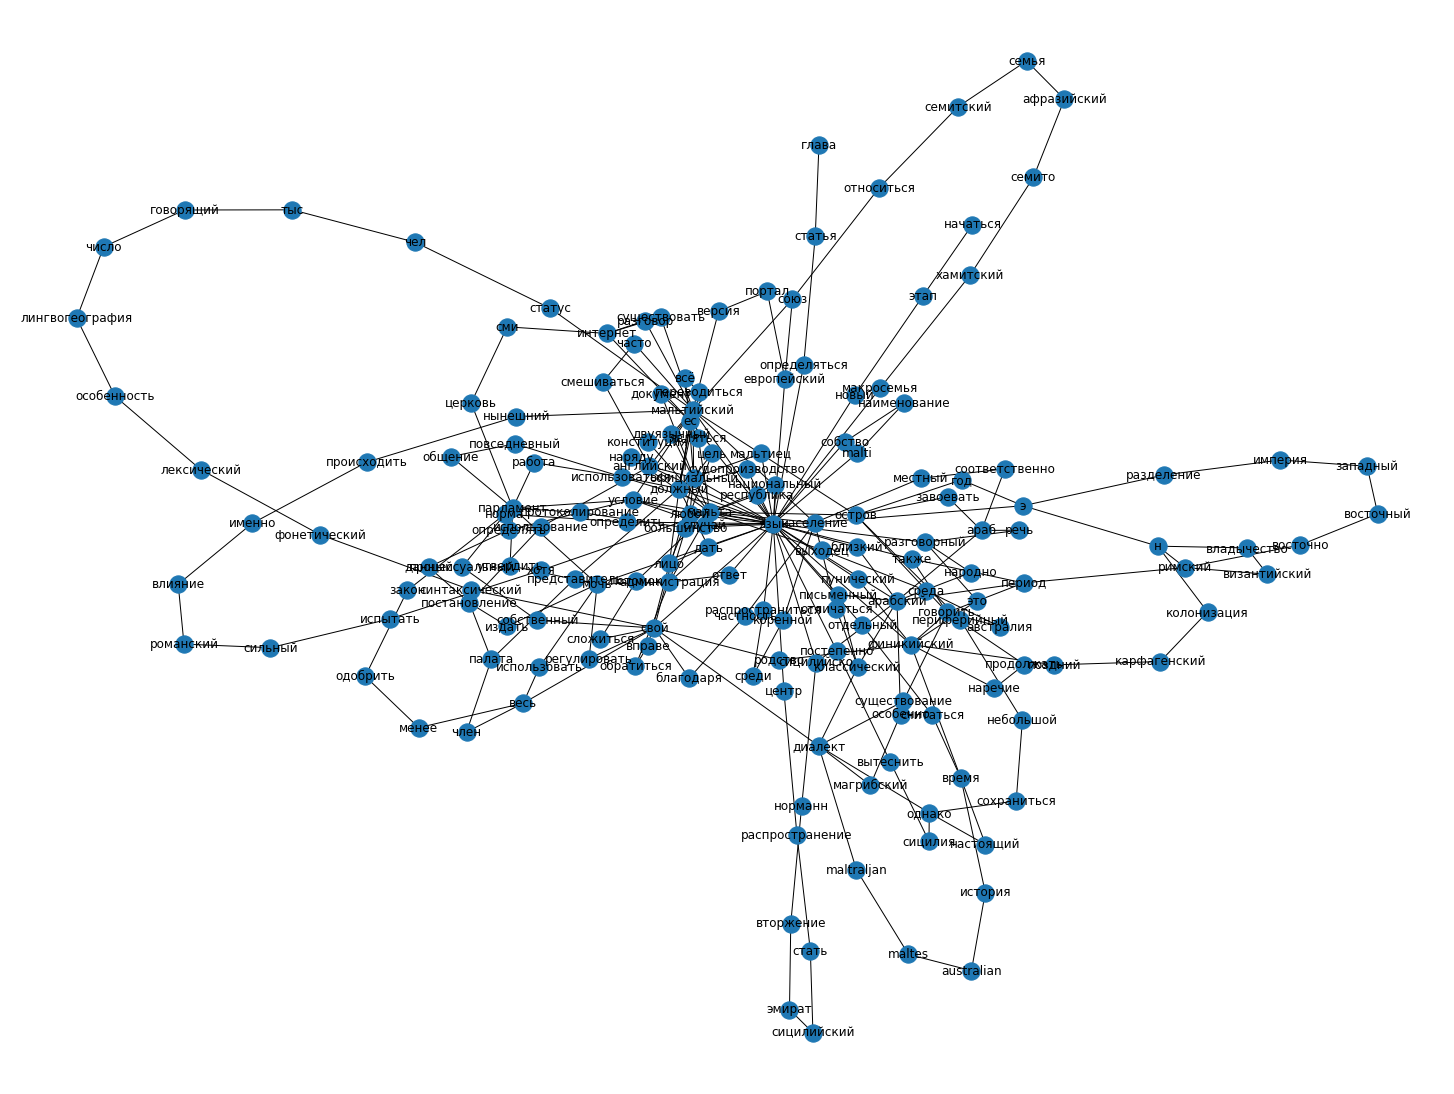

In [59]:
plt.figure(figsize=(20, 15))
nx.draw(G2, with_labels=True)

Для интересующихся: интерактивные графы можно рисовать с помощью [Plotly](https://plotly.com/python/network-graphs/)

# Другие методы

## Embeddings-based

- выделяем фразы-кандидаты
- векторизуем их
- векторизуем текст
- ранжируем кандидатов по близости к тексту

## Language model-based
* идея контрастивных методов:
  * сравниваем вероятности слов фразы и всей фразы в документе
  * сравниваем вероятности фразы в документе и целом корпусе

# Supervised методы

## Представление данных
- фразы + классы (да/нет)
- слова в тексте + тег для каждого слова

## ML-based подходы

- бинарная классификация

- sequence labelling / разметка последовательности

## Пример

`EM-алгоритм (англ. Expectation-maximization (EM) algorithm) — алгоритм, используемый в математической статистике для нахождения оценок максимального правдоподобия параметров вероятностных моделей, в случае, когда модель зависит от некоторых скрытых переменных.`

|кандидат|класс|
|-|-|
|`EM-алгоритм` | 1 |
|`алгоритм` | 0 |


Соответствие токенам:

`1 0 0 ...`

# Как улучшить выделение кандидатов?
(или вспомним синтаксис)

# SpaCy + UDPipe

Библиотека, которая предоставляет интерфейс spacy для моделей udpipe (увы, это всё ещё udpipe 1):
- есть метод `download()` для загрузки языковых пакетов
- обработка входного текста реализована как пайплайн

In [ ]:
#!pip install spacy-udpipe

In [ ]:
import spacy_udpipe

In [ ]:
spacy_udpipe.download("ru")

In [ ]:
text = "Эти типы стали есть в цехе."

nlp = spacy_udpipe.load("ru")

doc = nlp(text)
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.head, token.dep_, sep="\t")

# Работа с форматом conllu

In [ ]:
#!pip install conllu

In [ ]:
import conllu

In [ ]:
with open('ru_syntagrus-ud-test.conllu.txt') as f:
    sentences = conllu.parse(f.read())

In [ ]:
# Предложение = список токенов
sentences[5]

In [ ]:
# Токен - словарь
sentences[5][4]

# stanza
- стэнфордская библиотека, реализующая nlp-pipeline

In [ ]:
#!pip install stanza

In [60]:
import stanza

In [61]:
stanza.download("ru")

2021-10-27 14:13:17 INFO: Downloading default packages for language: ru (Russian)...


2021-10-27 14:14:18 INFO: Finished downloading models and saved to C:\Users\User\stanza_resources.


In [65]:
nlp = stanza.Pipeline("ru", use_gpu=False)
nlp(text)

2021-10-27 14:21:09 INFO: Loading these models for language: ru (Russian):
| Processor | Package   |
-------------------------
| tokenize  | syntagrus |
| pos       | syntagrus |
| lemma     | syntagrus |
| depparse  | syntagrus |
| ner       | wikiner   |

2021-10-27 14:21:09 INFO: Use device: cpu
2021-10-27 14:21:09 INFO: Loading: tokenize
2021-10-27 14:21:09 INFO: Loading: pos
2021-10-27 14:21:10 INFO: Loading: lemma
2021-10-27 14:21:10 INFO: Loading: depparse
2021-10-27 14:21:10 INFO: Loading: ner
2021-10-27 14:21:12 INFO: Done loading processors!


[
  [
    {
      "id": 1,
      "text": "Эти",
      "lemma": "этот",
      "upos": "DET",
      "feats": "Case=Nom|Number=Plur",
      "head": 2,
      "deprel": "det",
      "start_char": 0,
      "end_char": 3,
      "ner": "O"
    },
    {
      "id": 2,
      "text": "типы",
      "lemma": "тип",
      "upos": "NOUN",
      "feats": "Animacy=Inan|Case=Nom|Gender=Masc|Number=Plur",
      "head": 3,
      "deprel": "nsubj",
      "start_char": 4,
      "end_char": 8,
      "ner": "O"
    },
    {
      "id": 3,
      "text": "стали",
      "lemma": "стать",
      "upos": "VERB",
      "feats": "Aspect=Perf|Mood=Ind|Number=Plur|Tense=Past|VerbForm=Fin|Voice=Act",
      "head": 0,
      "deprel": "root",
      "start_char": 9,
      "end_char": 14,
      "ner": "O"
    },
    {
      "id": 4,
      "text": "есть",
      "lemma": "быть",
      "upos": "VERB",
      "feats": "Aspect=Imp|Person=3|Tense=Pres|VerbForm=Inf|Voice=Act",
      "head": 3,
      "deprel": "xcomp",
      "start_